# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
from data_transformation import CleanData
from features_library import FeatureTransformations
from regression import (
                        BaseReg,
                        RandomForestReg, 
                        HistGradientBoostingReg, 
                        SGDReg, 
                        ElasticNetReg, 
                        TheilSenReg,
                        RANSACReg
                        )
from trading_strategies import TradingStrategy
from performance_metrics import PerformanceMetrics

# Load Data

In [4]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [5]:
dict_assets = {}
ASSETS_SELECTED = [
    'BTC-USD',
    'ETH-USD',
    'XRP-USD',
    'LTC-USD',
]

for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    if not asset_name in ASSETS_SELECTED:
        continue
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [6]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    if fd_name.startswith("F-F"):
        df_fd = df_fd.loc[df_fd['Date']>19700101]
        df_fd["Date"] = df_fd["Date"].astype(str)
        df_fd["Date"] = df_fd["Date"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()
    preproc.ffill()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df

In [7]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

Tcm1mo  Tcm3mo  Tcm1yr  Tcm5yr  Tcm10yr
1997-01-02  0.0519  0.0519  0.0563  0.0630   0.0654
1997-01-03  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-04  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-05  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-06  0.0517  0.0517  0.0561  0.0630   0.0654
...            ...     ...     ...     ...      ...
2023-03-16  0.0422  0.0474  0.0449  0.0372   0.0356
2023-03-17  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-18  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-19  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-20  0.0434  0.0481  0.0434  0.0356   0.0347

[9574 rows x 5 columns]

# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [8]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [9]:
dict_fd['S_P 500 index']['Volume'] = np.nan
# dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [10]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [11]:
# for asset_name, df_asset in dict_assets.items():
#     scaler = StandardScaler()
#     df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
#     dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

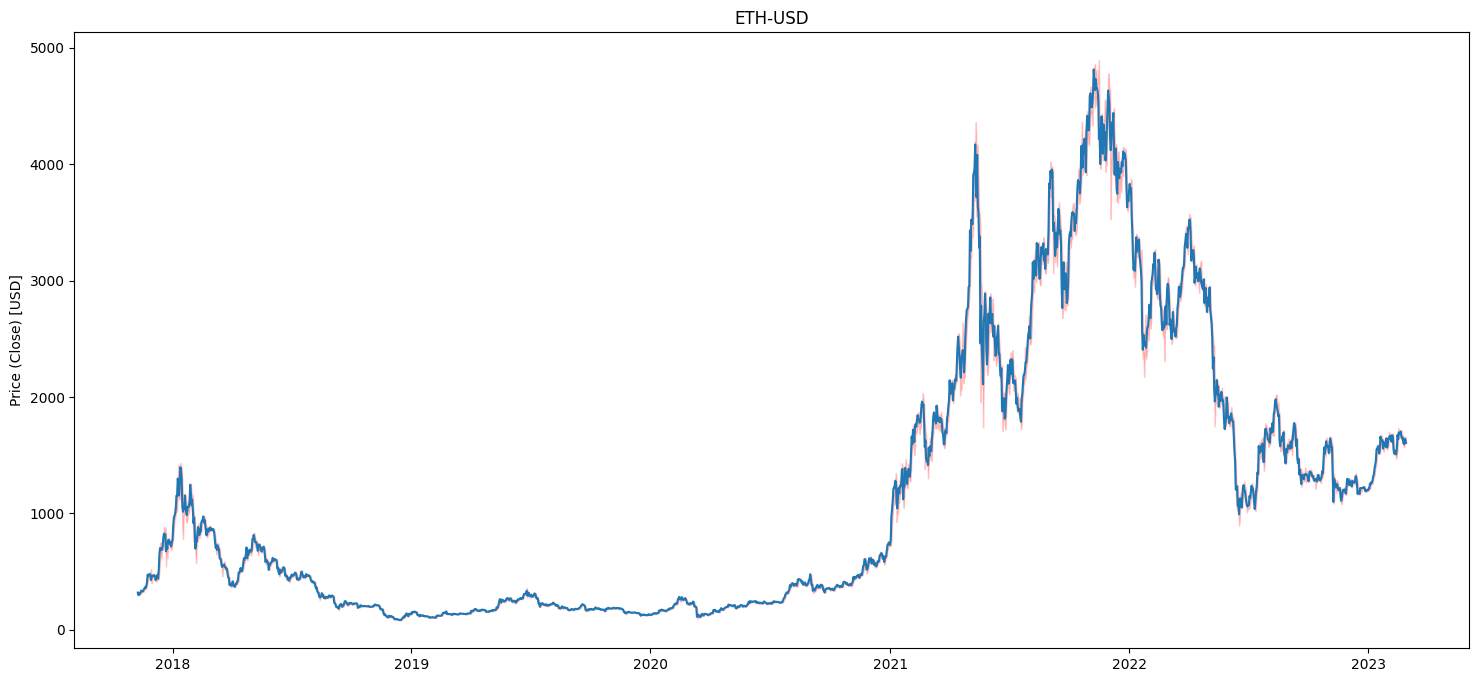

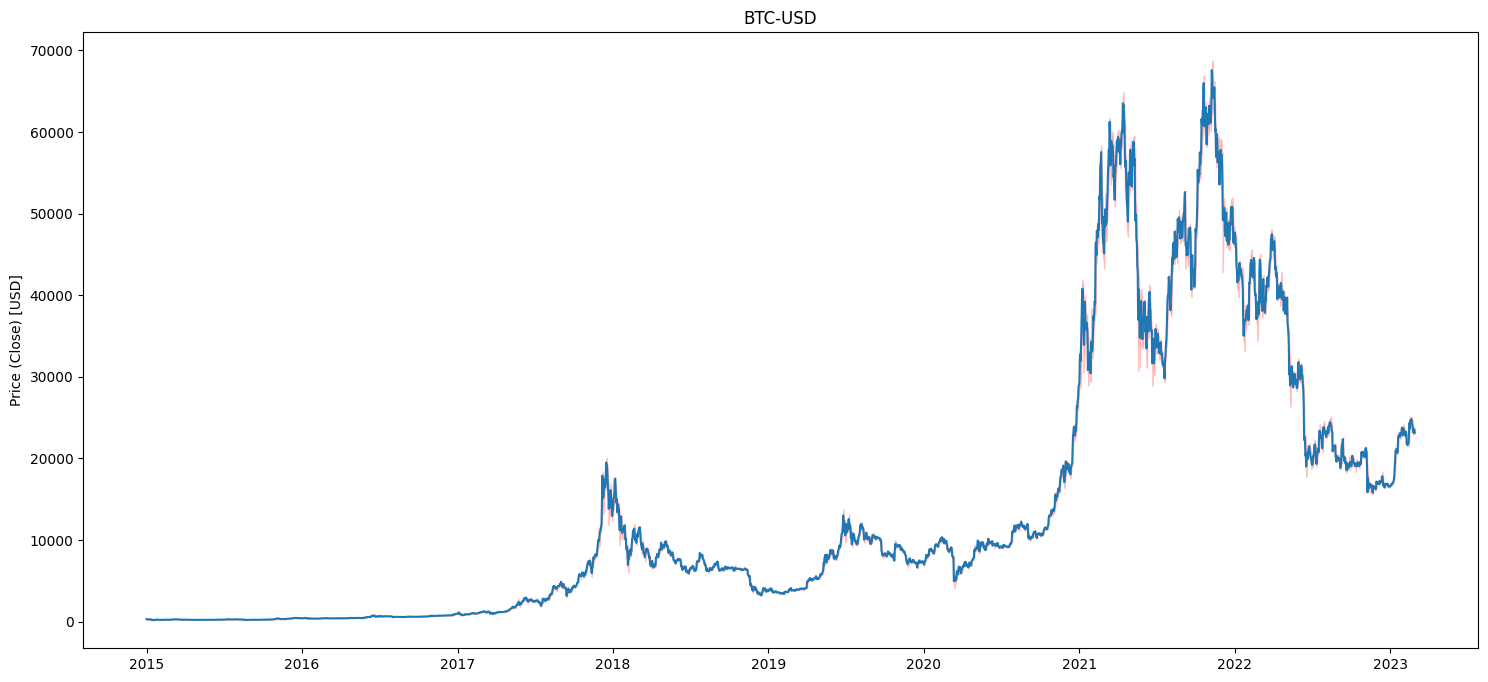

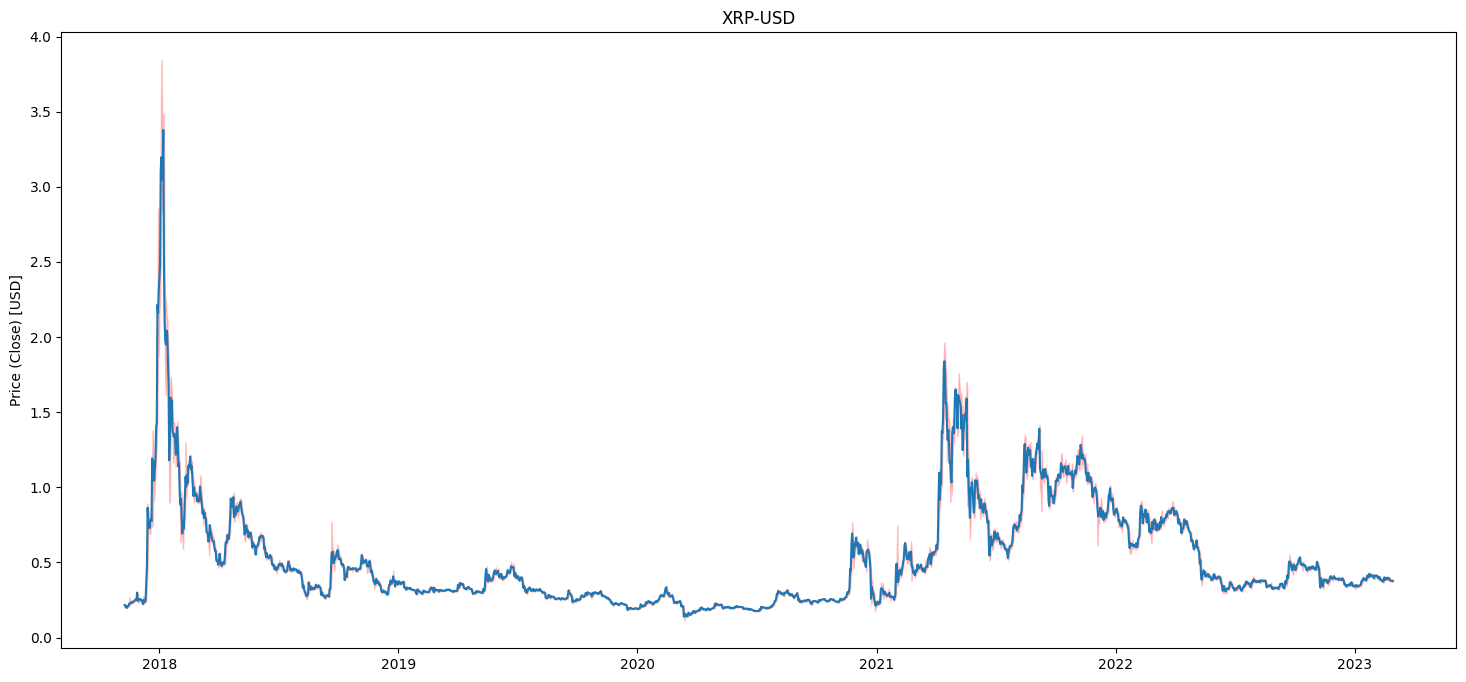

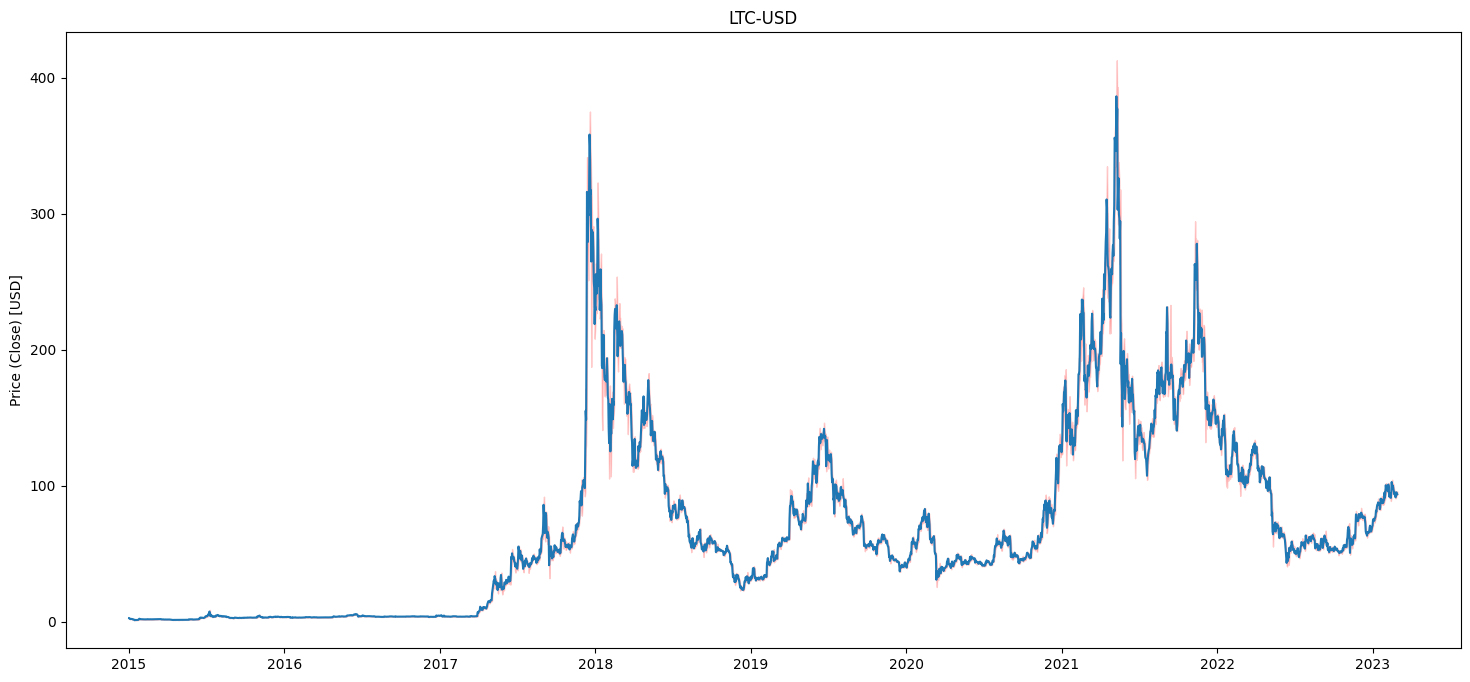

In [12]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

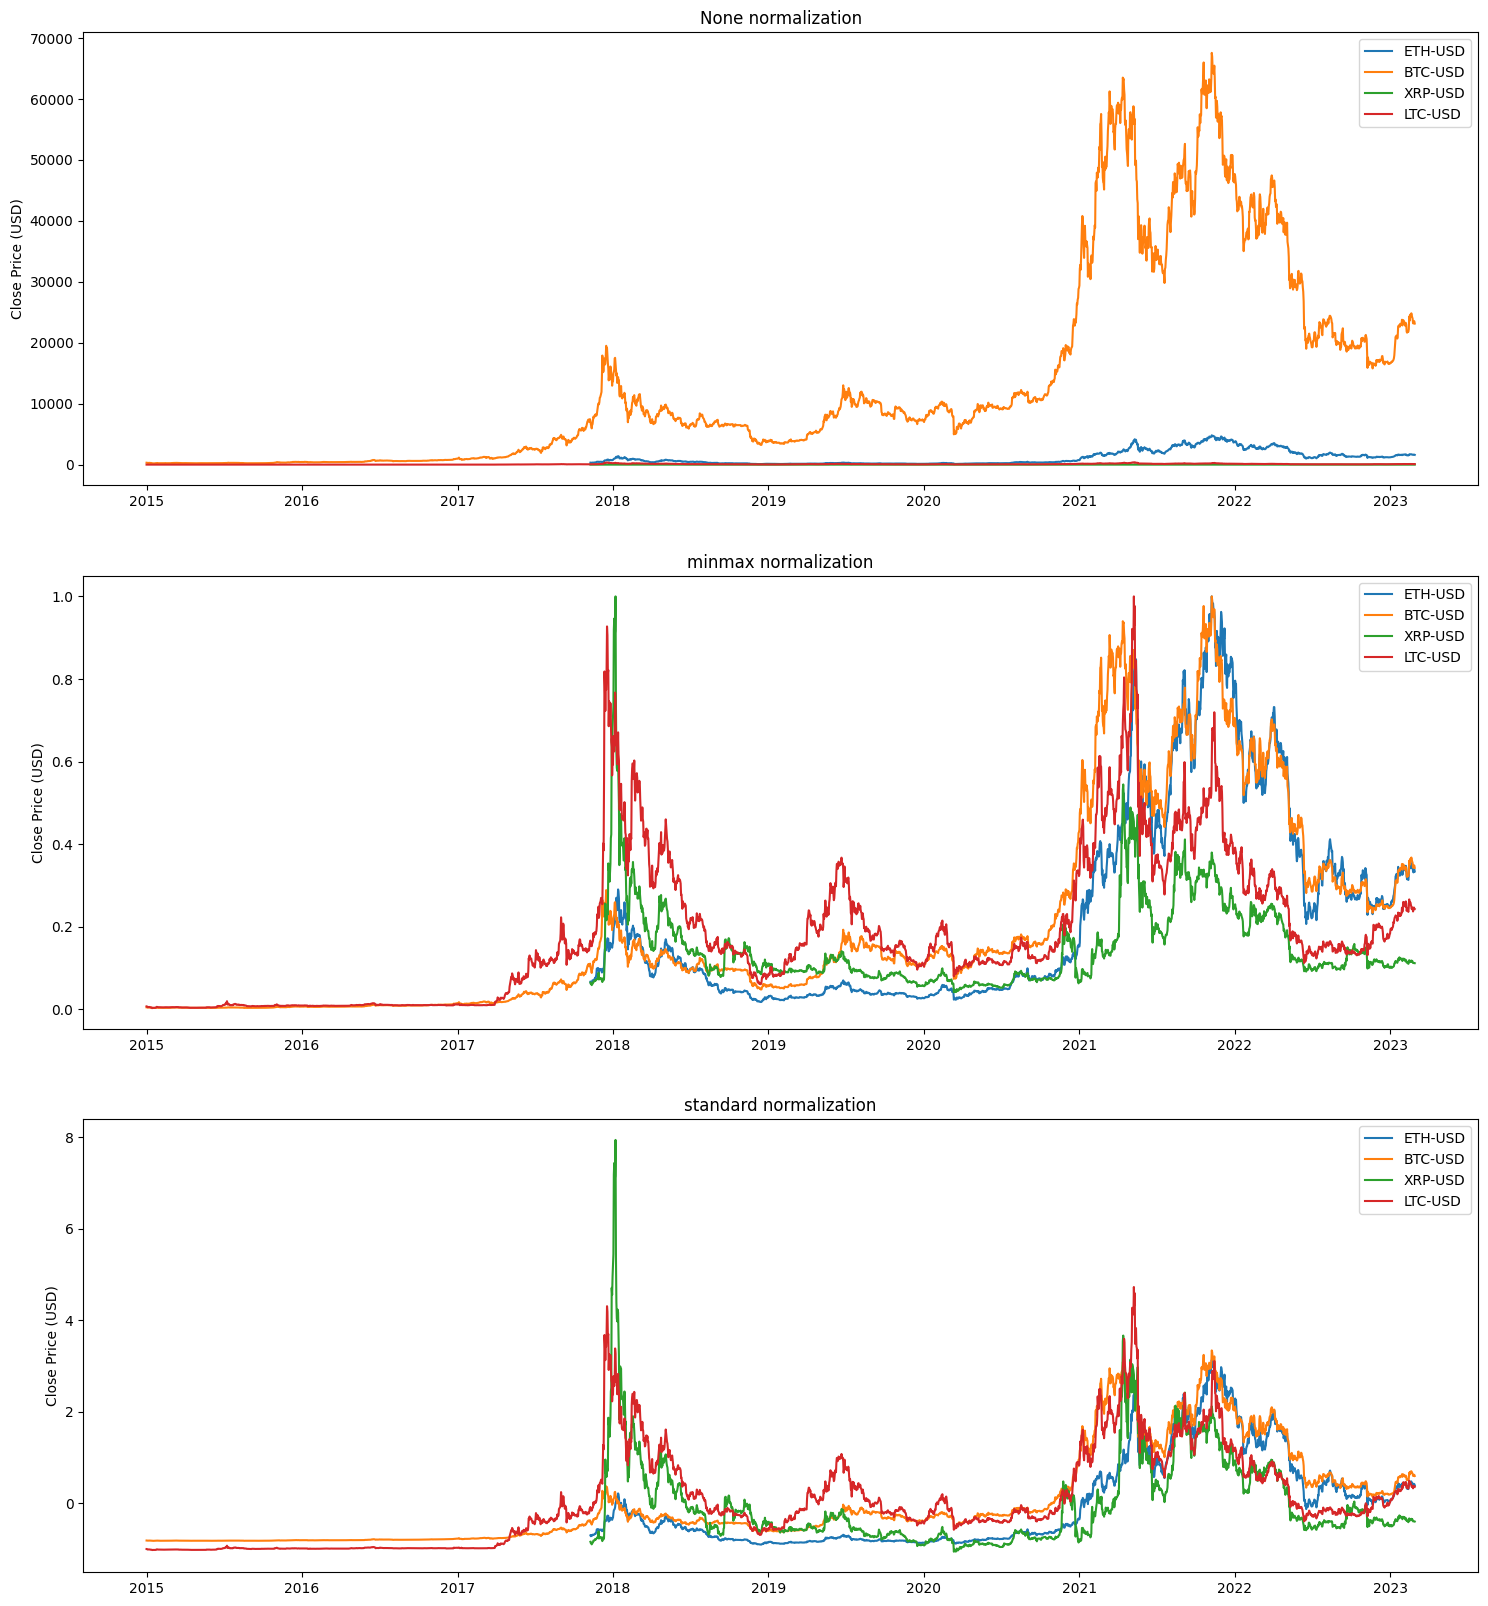

In [13]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset # ['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(f"{str(norm_method)} normalization")
        ax.set_ylabel(f"Close Price (USD)")
        ax.legend()

plt.show()

## Describe Returns

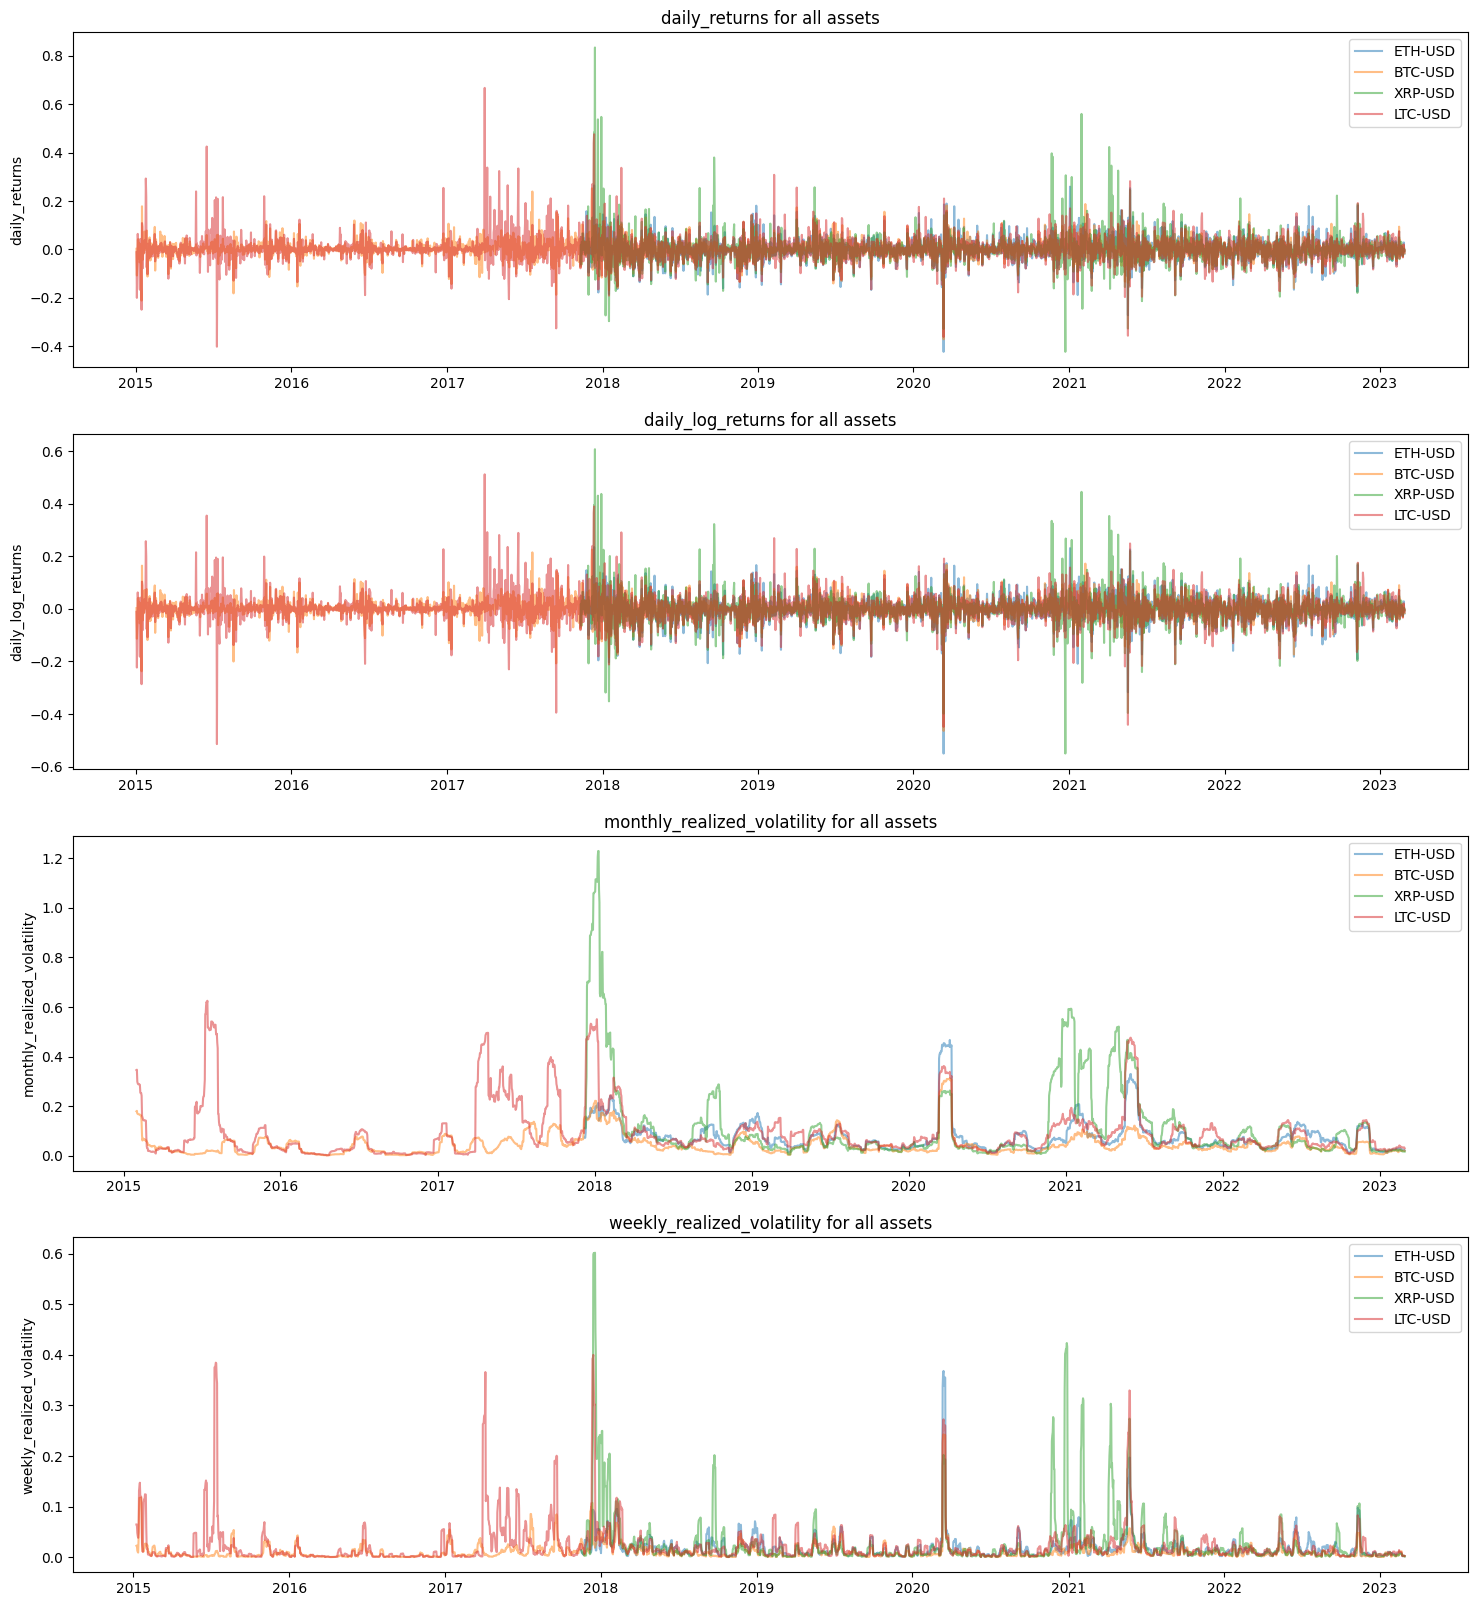

In [14]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset#['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name, alpha=0.5)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

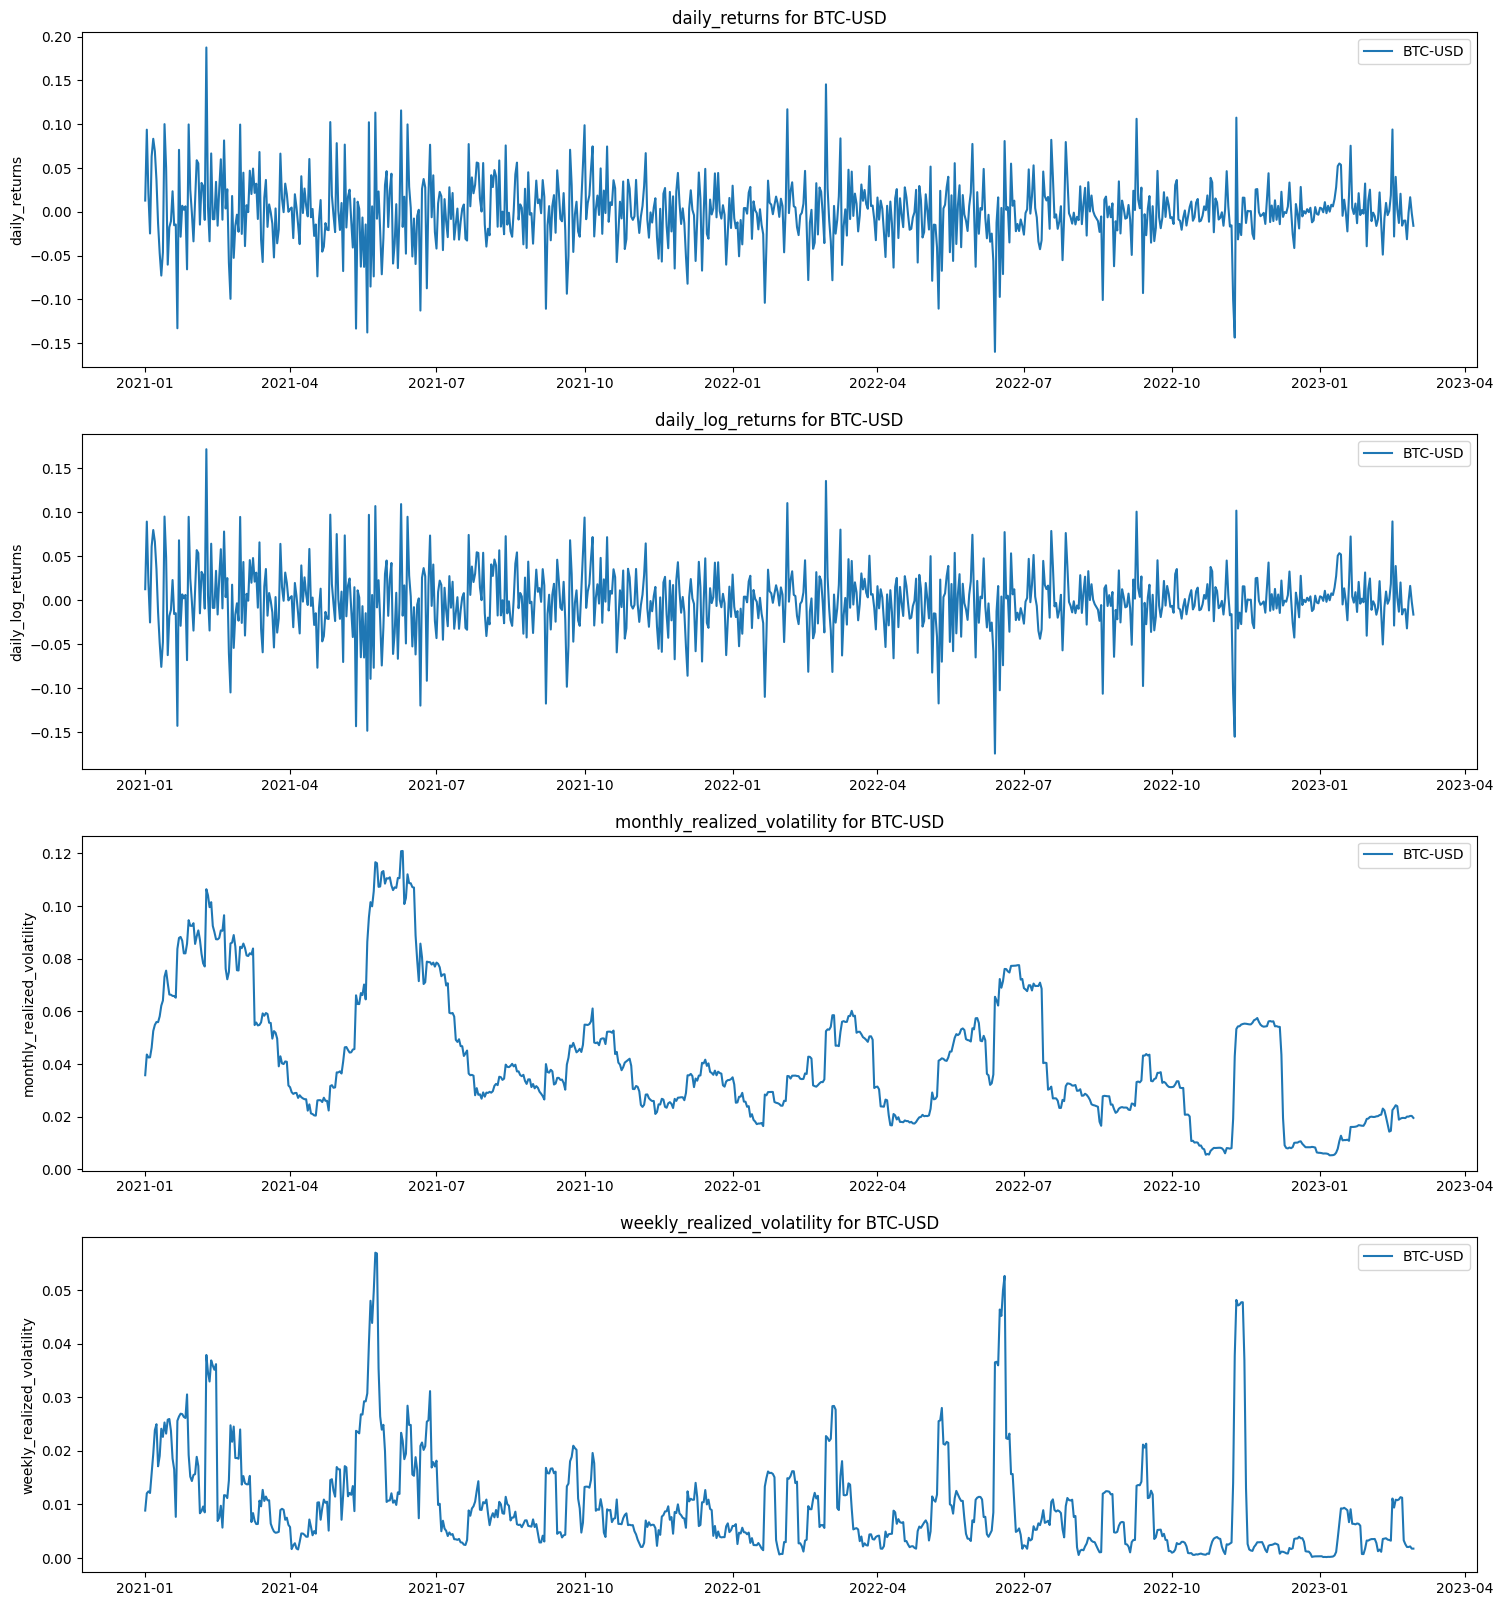

In [15]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [26]:
df_asset = dict_assets['BTC-USD']

<Axes: >

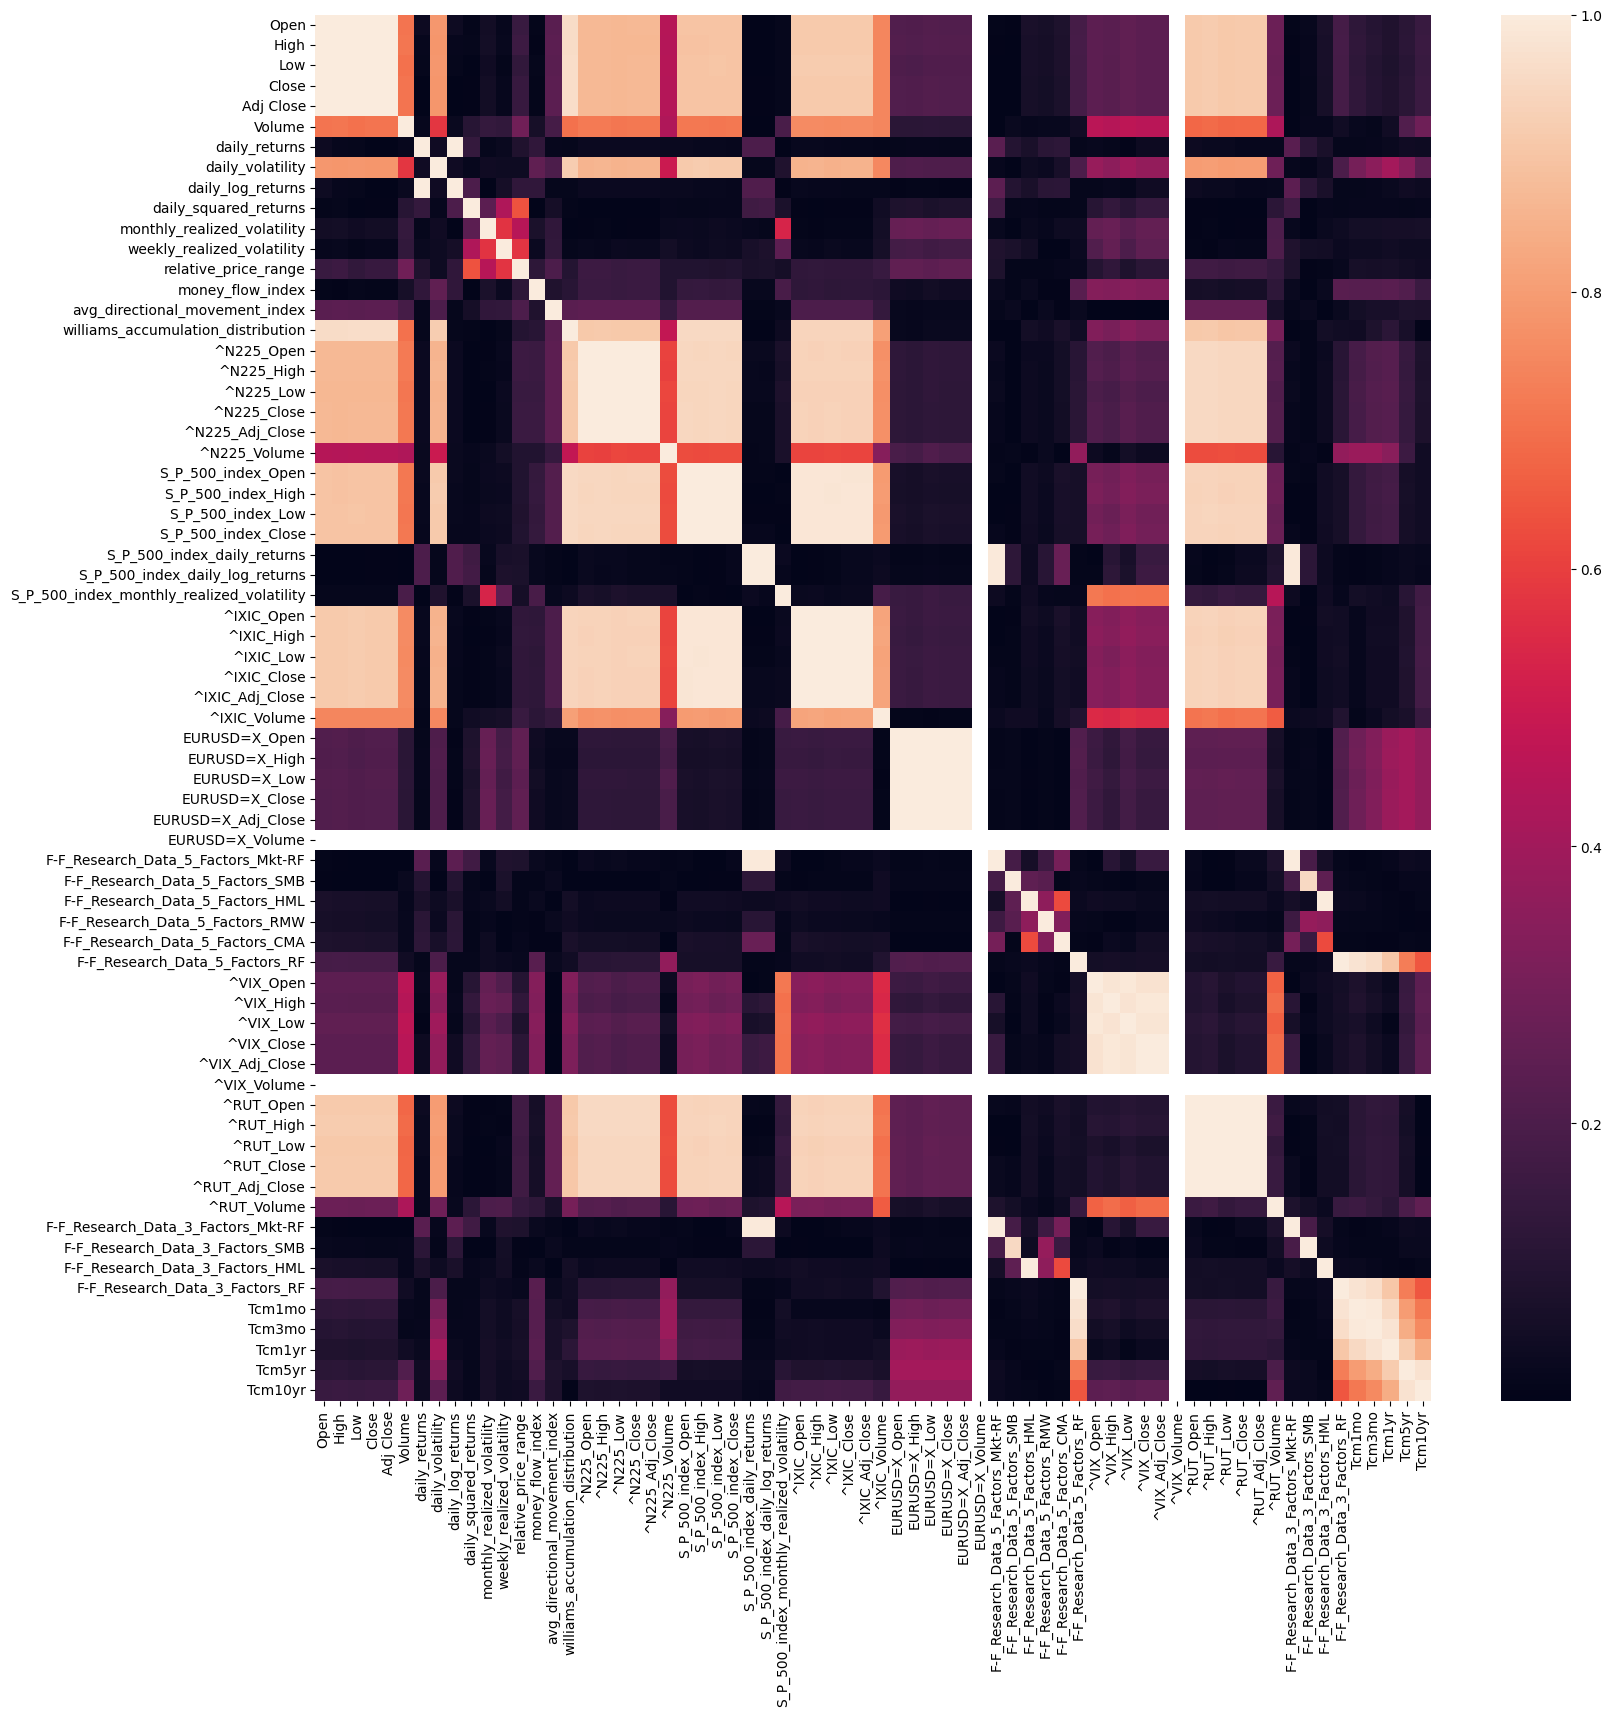

In [17]:
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

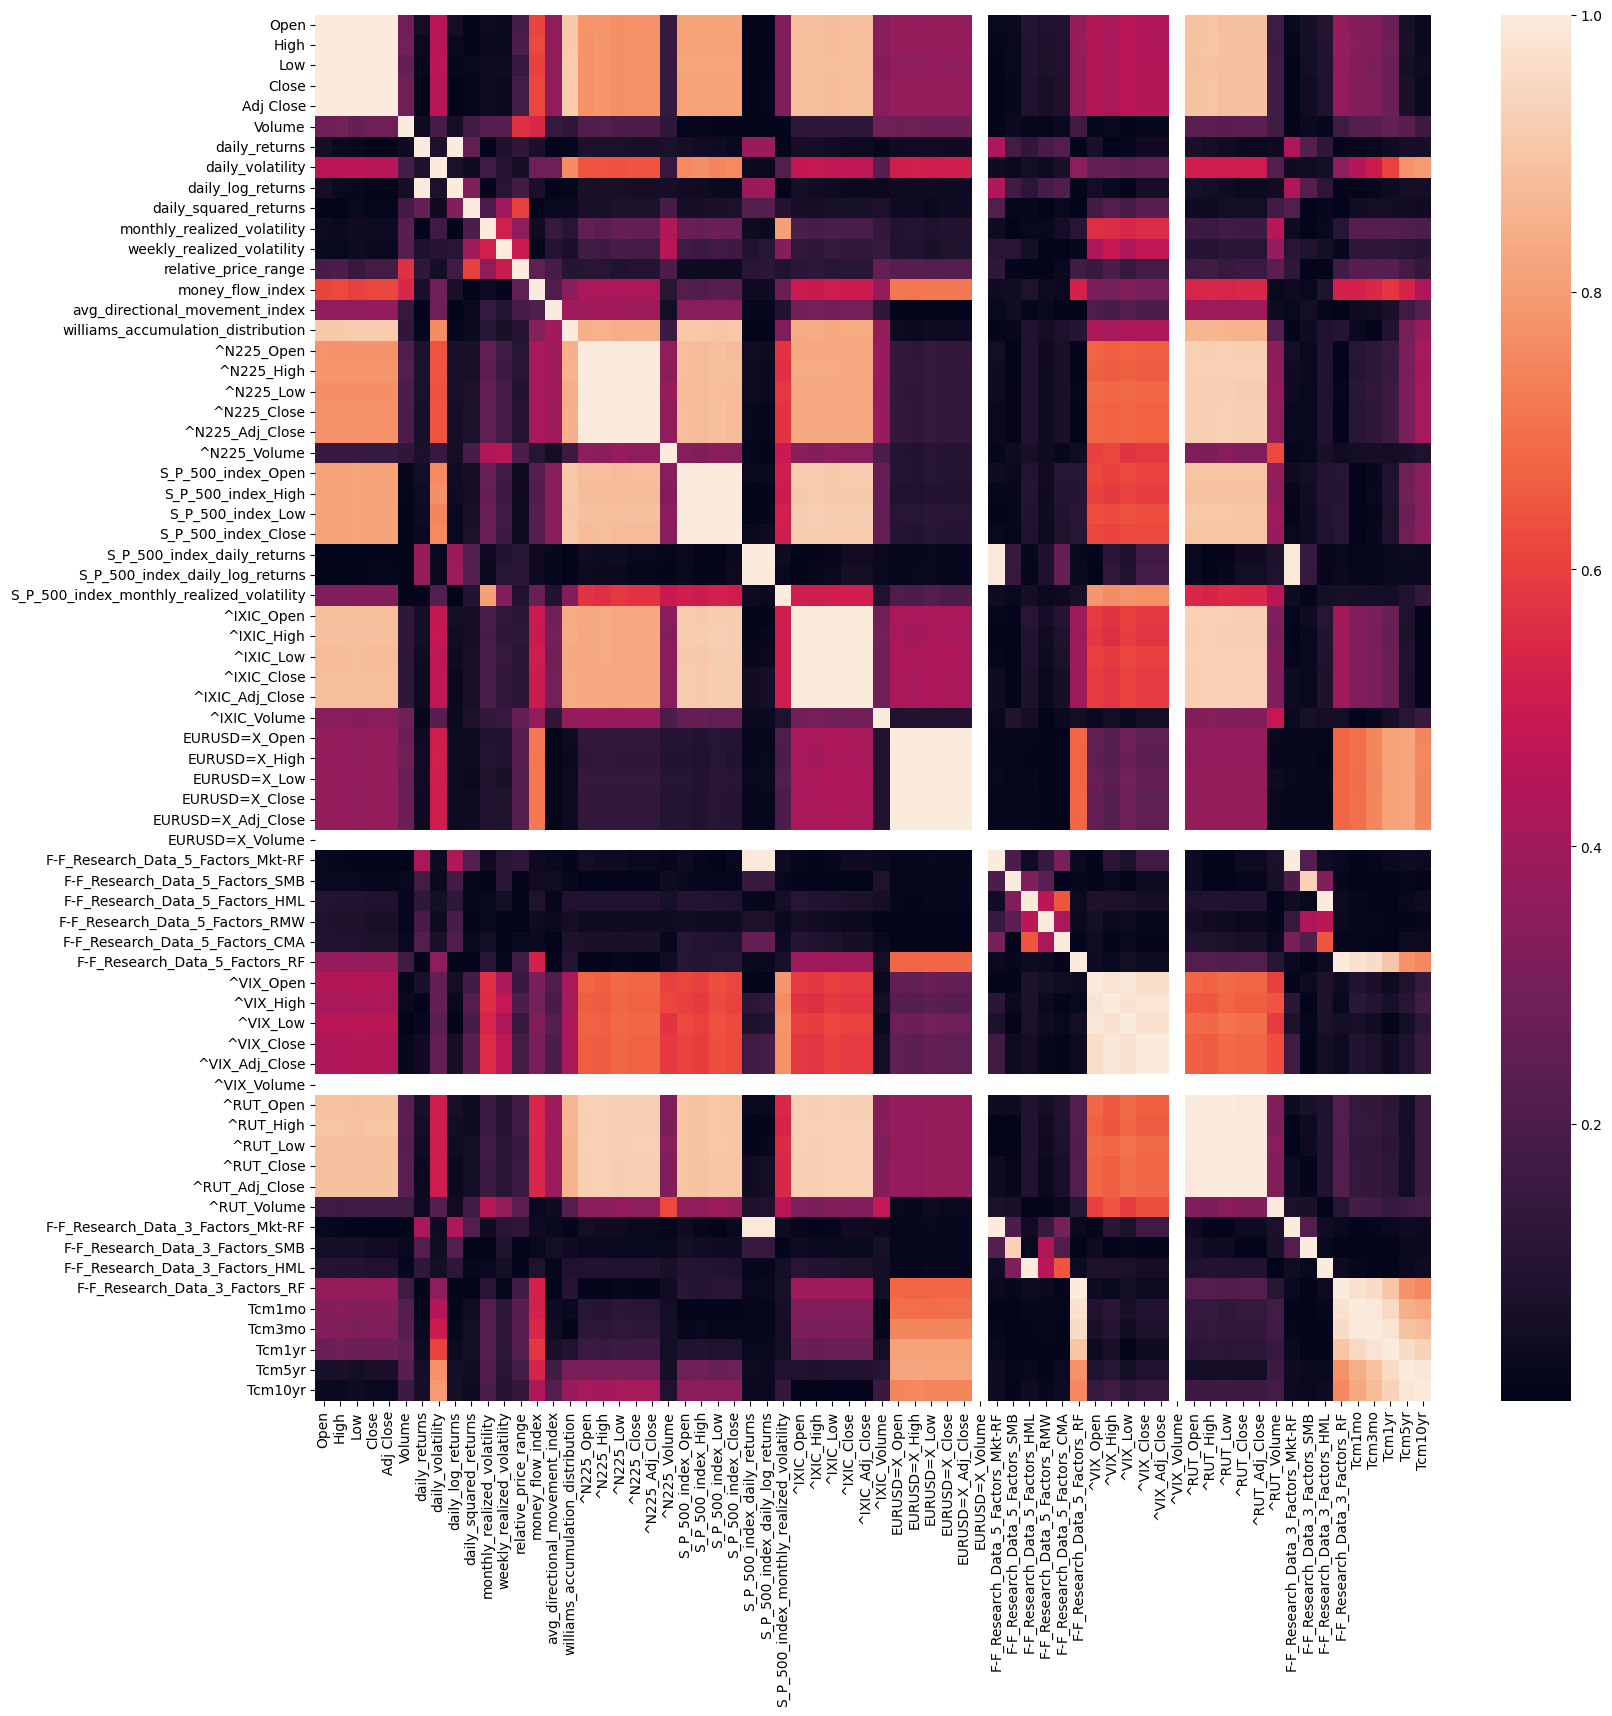

In [18]:
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

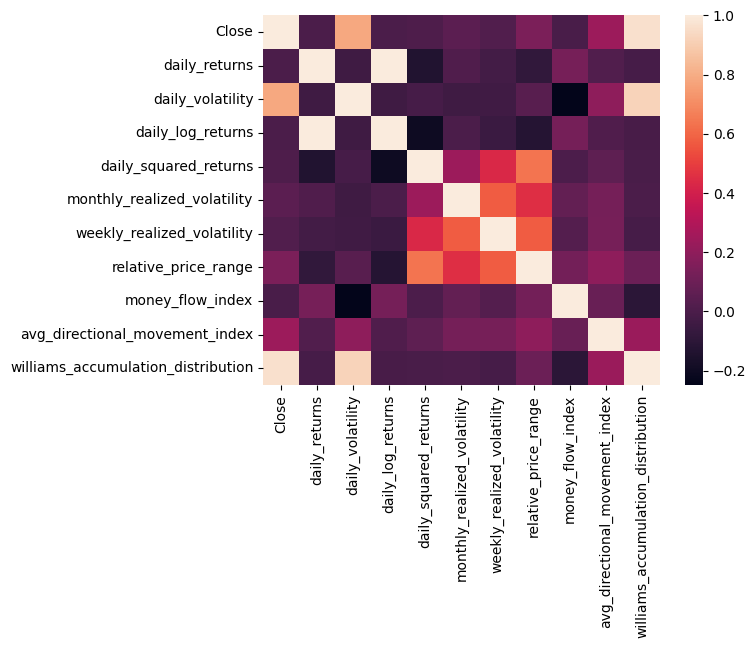

In [19]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

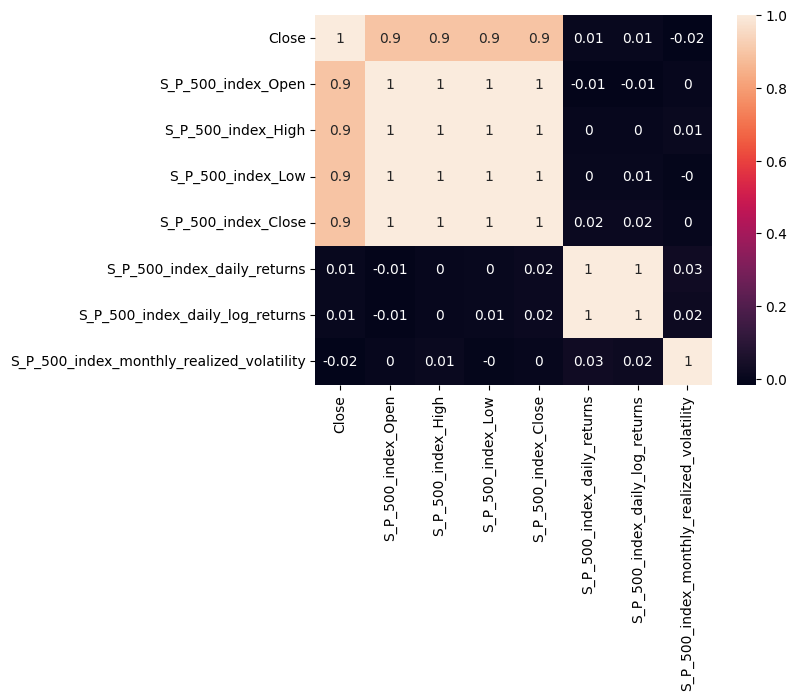

In [32]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    annot=np.round(df_asset_corr.values, 2),
)

<Axes: >

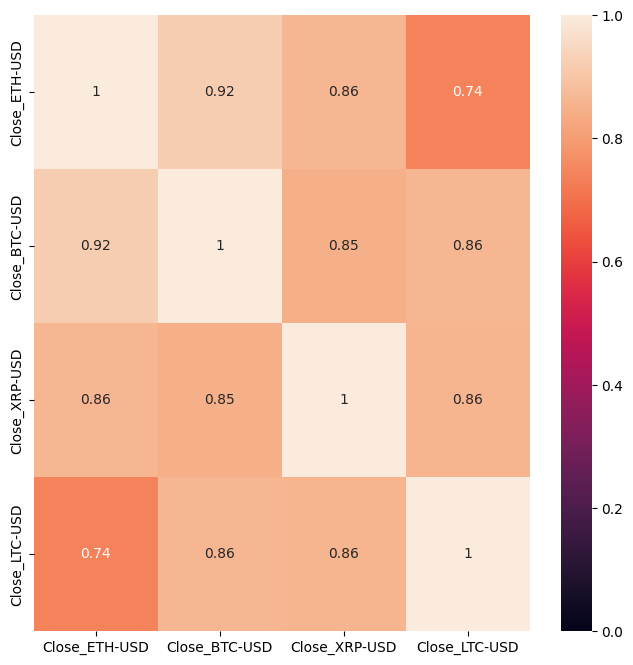

In [21]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

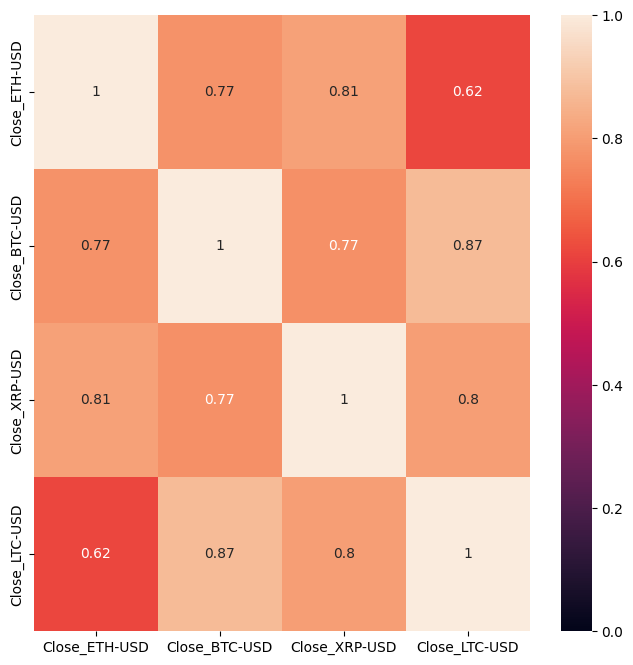

In [22]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [23]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

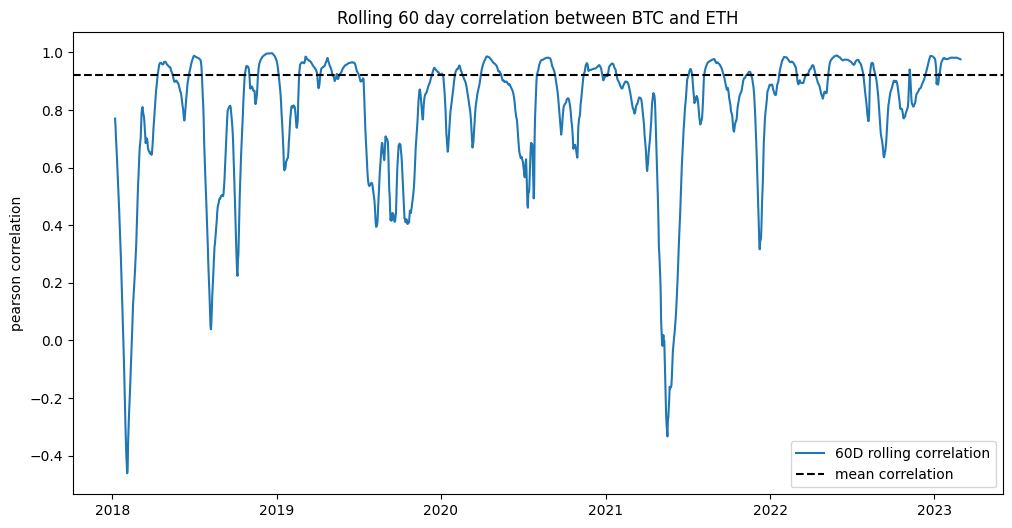

In [24]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [25]:
pd.options.display.max_columns = 100

In [75]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

Close_ETH-USD  Close_BTC-USD  Close_XRP-USD  Close_LTC-USD
count       1938.000000    2981.000000    1938.000000    2981.000000
mean        1142.440624   13481.524369       0.520195      69.656052
std         1172.103874   16181.118403       0.359689      66.984527
min           84.308296     178.102997       0.139635       1.157010
25%          213.643108     920.382019       0.288724       4.219910
50%          559.634278    7556.237793       0.388867      54.807610
75%         1718.111817   19044.107422       0.656891     100.378006
max         4812.087402   67566.828125       3.377810     386.450775
kurtosis       0.361284       1.130637       9.853790       1.653547
skewness       1.179694       1.472561       2.419911       1.291831

# Regression

In [11]:
df_asset = dict_assets['BTC-USD']

In [12]:
TARGET = 'daily_log_returns'

In [13]:
FEATURES_LIST_HAND_PICKED = [
    'Close', 'daily_volatility',
    'monthly_realized_volatility', 'weekly_realized_volatility',
    'relative_price_range', 'money_flow_index',
    'avg_directional_movement_index', 'williams_accumulation_distribution',
    'on_balance_volume', 'pma_10', 'pma_30', 'pma_60',
    
    'S_P_500_index_Close', #'S_P_500_index_monthly_realized_volatility', 
    'S_P_500_index_daily_log_returns',

    '^N225_Close', '^IXIC_Close', 'EURUSD=X_Close', '^VIX_Close', '^RUT_Close',

    'Tcm1mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr',

    'F-F_Research_Data_5_Factors_Mkt-RF', 'F-F_Research_Data_5_Factors_SMB',
    'F-F_Research_Data_5_Factors_HML', 'F-F_Research_Data_5_Factors_RMW',
    'F-F_Research_Data_5_Factors_CMA', 'F-F_Research_Data_5_Factors_RF',

    ## F-F3 are subset of F-F5
    # 'F-F_Research_Data_3_Factors_Mkt-RF', 'F-F_Research_Data_3_Factors_SMB', 
    # 'F-F_Research_Data_3_Factors_HML', 'F-F_Research_Data_3_Factors_RF',
]

len(FEATURES_LIST_HAND_PICKED)

29

<Axes: >

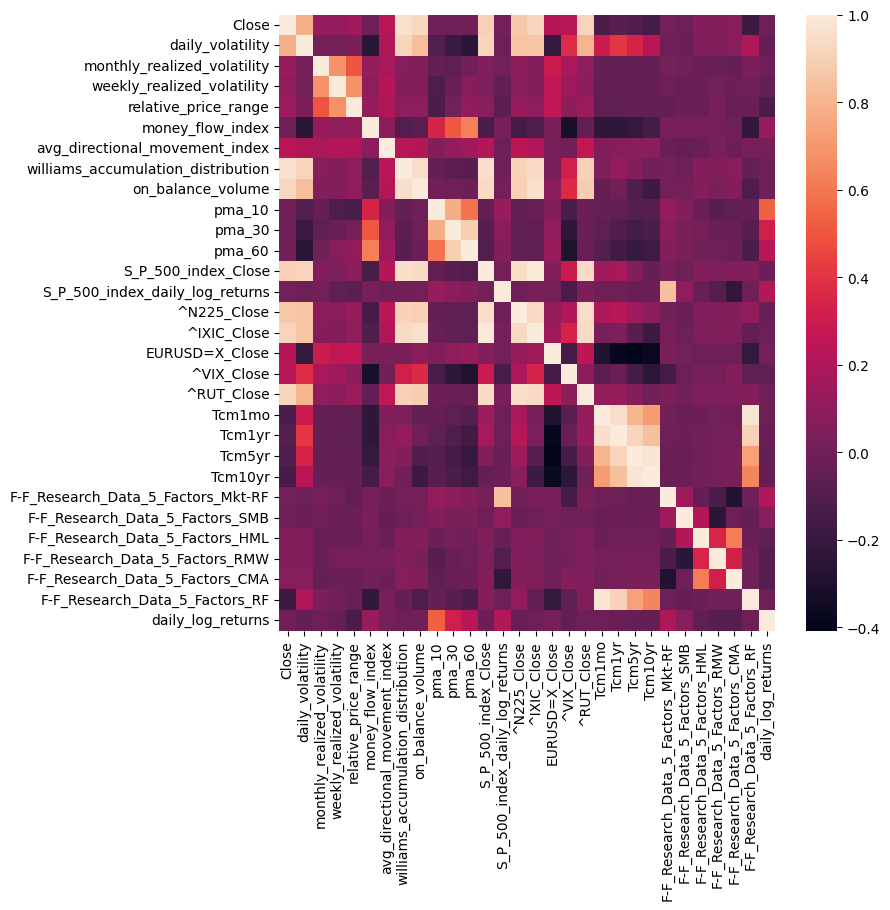

In [14]:
corr = df_asset[FEATURES_LIST_HAND_PICKED+[TARGET]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    # annot=corr.values,
    ax=plt.gca(),
    # vmin=0,
)

In [21]:
TRAIN_DATE_RANGE = ("2018-01-01", "2021-12-31")
TEST_DATE_RANGE = ("2022-01-01", "2022-12-31")
OOS_DATE_RANGE = ("2023-01-01", "2023-01-31")

In [107]:
def train_test_split(df_asset, TRAIN_DATE_RANGE, TEST_DATE_RANGE, OOS_DATE_RANGE, FEATURES_LIST, TARGET, norm=False):
    
    df_asset_tts = df_asset.copy()
    df_asset_tts[TARGET] = df_asset_tts[TARGET]#.shift(periods=-1)
    df_asset_tts = df_asset_tts[FEATURES_LIST + [TARGET]]
    print(f"{df_asset_tts.shape=}")
    if norm:
        scaler = StandardScaler()
        df_asset_tts[FEATURES_LIST] = scaler.fit_transform(df_asset_tts[FEATURES_LIST])
        with open("./assets/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
    
    df_asset_train = df_asset_tts[TRAIN_DATE_RANGE[0]: TRAIN_DATE_RANGE[1]]
    df_asset_test = df_asset_tts[TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]
    df_asset_oos = df_asset_tts[OOS_DATE_RANGE[0]: OOS_DATE_RANGE[1]]
    
    X_train, Y_train = df_asset_train[FEATURES_LIST], df_asset_train[TARGET]
    X_test, Y_test = df_asset_test[FEATURES_LIST], df_asset_test[TARGET]
    X_oos, Y_oos = df_asset_oos[FEATURES_LIST], df_asset_oos[TARGET]

    print(f"""
    {X_train.shape=}, {Y_train.shape=}, 
    {X_test.shape=}, {Y_test.shape=},
    {X_oos.shape=}, {Y_oos.shape=},
    """)

    return X_train, Y_train, X_test, Y_test, X_oos, Y_oos

In [108]:
X_train, Y_train, X_test, Y_test, X_oos, Y_oos = train_test_split(
    df_asset=df_asset, 
    TRAIN_DATE_RANGE=TRAIN_DATE_RANGE, 
    TEST_DATE_RANGE=TEST_DATE_RANGE, 
    OOS_DATE_RANGE=OOS_DATE_RANGE,
    FEATURES_LIST=FEATURES_LIST_HAND_PICKED, 
    TARGET=TARGET, 
    norm=False,
    )

df_asset_tts.shape=(2981, 30)

    X_train.shape=(1461, 29), Y_train.shape=(1461,), 
    X_test.shape=(365, 29), Y_test.shape=(365,),
    X_oos.shape=(31, 29), Y_oos.shape=(31,),
    


In [109]:
X_train.describe()

Close  daily_volatility  monthly_realized_volatility  \
count   1461.000000       1461.000000                  1461.000000   
mean   18375.242011       5780.942251                     0.206010   
std    17760.299775       3617.367291                     0.088296   
min     3236.761719       2909.620607                     0.060190   
25%     7116.804199       3826.496687                     0.149925   
50%     9475.277344       3991.343328                     0.186478   
75%    29001.720703       4840.610266                     0.243938   
max    67566.828125      15892.528466                     0.559400   

       weekly_realized_volatility  relative_price_range  money_flow_index  \
count                 1461.000000           1461.000000       1461.000000   
mean                     0.092334              0.049900         52.383831   
std                      0.053945              0.039396          2.115826   
min                      0.004900              0.004611         48.591295   
25%                      0.057206              0.024123         50.624529   
50%                      0.083134              0.040266         52.181503   
75%                      0.115833              0.061445         53.506543   
max                      0.492605              0.479889         60.529573   

       avg_directional_movement_index  williams_accumulation_distribution  \
count                     1461.000000                         1461.000000   
mean                         0.958797                        30631.816191   
std                          0.052040                        26899.916954   
min                          0.697569                         9086.484633   
25%                          0.941723                        12958.157979   
50%                          0.979842                        17179.376229   
75%                          0.995065                        43423.535398   
max                          0.999992                       105875.576406   

       on_balance_volume       pma_10  ...       Tcm1mo       Tcm1yr  \
count       1.461000e+03  1461.000000  ...  1461.000000  1461.000000   
mean        8.953267e+11     1.004735  ...     0.010897     0.012150   
std         7.570834e+11     0.067867  ...     0.009698     0.010448   
min         8.946056e+10     0.610077  ...     0.000000     0.000400   
25%         1.951241e+11     0.969754  ...     0.000700     0.001200   
50%         6.087130e+11     1.004452  ...     0.014800     0.015400   
75%         1.683672e+12     1.040481  ...     0.020100     0.023000   
max         2.687268e+12     1.242924  ...     0.025100     0.027400   

            Tcm5yr      Tcm10yr  F-F_Research_Data_5_Factors_Mkt-RF  \
count  1461.000000  1461.000000                         1461.000000   
mean      0.015235     0.018465                            0.081629   
std       0.009371     0.008117                            1.313268   
min       0.001900     0.005200                          -12.000000   
25%       0.007100     0.012500                           -0.410000   
50%       0.014400     0.016800                            0.130000   
75%       0.025100     0.027100                            0.700000   
max       0.030900     0.032400                            9.340000   

       F-F_Research_Data_5_Factors_SMB  F-F_Research_Data_5_Factors_HML  \
count                      1461.000000                      1461.000000   
mean                         -0.000589                        -0.013018   
std                           0.756930                         1.022294   
min                          -4.550000                        -5.000000   
25%                          -0.440000                        -0.500000   
50%                          -0.040000                        -0.090000   
75%                           0.400000                         0.440000   
max                           5.710000                         6.740000   

       F-F_Research_Data_5_Fac

## Fit and Score Regression Models

### ARIMA (Not working)

In [49]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

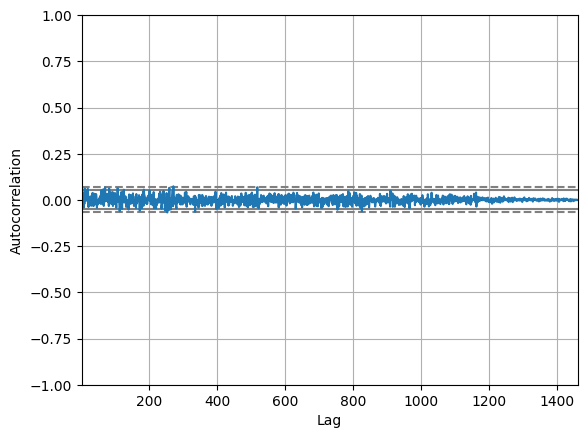

In [48]:
autocorrelation_plot(Y_train)

In [70]:
model_arima = ARIMA(endog=Y_train, exog=X_train, order=(0,1,7))

                               SARIMAX Results                                
Dep. Variable:      daily_log_returns   No. Observations:                 1461
Model:                 ARIMA(0, 1, 7)   Log Likelihood                2786.745
Date:                Tue, 11 Apr 2023   AIC                          -5499.491
Time:                        23:53:12   BIC                          -5303.902
Sample:                    01-01-2017   HQIC                         -5426.528
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Close                                 -0.6285      0.104     -6.046      0.000      -0.832      -0.425
daily_volatility                      -1.1212      0.239   

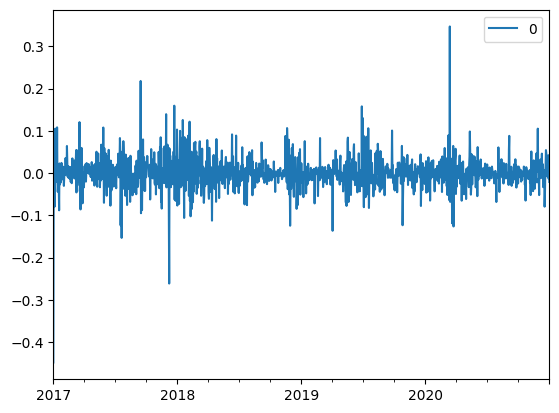

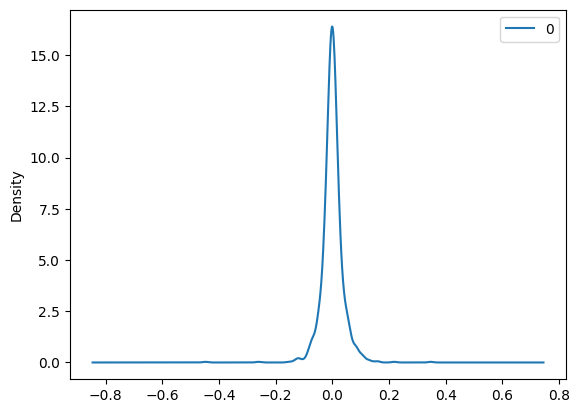

                 0
count  1461.000000
mean      0.000343
std       0.037755
min      -0.448363
25%      -0.015641
50%      -0.000436
75%       0.015390
max       0.346972


In [71]:
model_fit = model_arima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [74]:
Y_pred_ARIMA = model_fit.forecast(exog=X_test, steps=X_test.shape[0])

In [75]:
r2_score(Y_test, Y_pred_ARIMA)

-95948080.25930463

### Regressions

**Random Forest Regression**

In [ ]:
# Grid-Search for Best Parameters
"""
PARAMS_GS_RFR = {
    "n_estimators": [100, 1000, 5000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

rfr = RandomForestReg({})
rfr.grid_search_CV(
    X_train=X_train, 
    Y_train=Y_train,
    param_grid=PARAMS_GS_RFR,
    cv=None, 
    refit=True,
    scoring='r2', 
    n_jobs=-1, 
    verbose=5,
)
"""

In [110]:
PARAMS_RFR = {
    "n_estimators": 100,
    "criterion": "squared_error",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 1,
}

rfr = RandomForestReg(**PARAMS_RFR)
rfr.fit_regressor(X_train, Y_train)
# make the prediction on the test set
Y_pred = rfr.predict_regressor(X_test)
# make the prediction on the out-of-sampling set
Y_pred_oos = rfr.predict_regressor(X_oos)
rfr.score_regressor(X_test, Y_test)

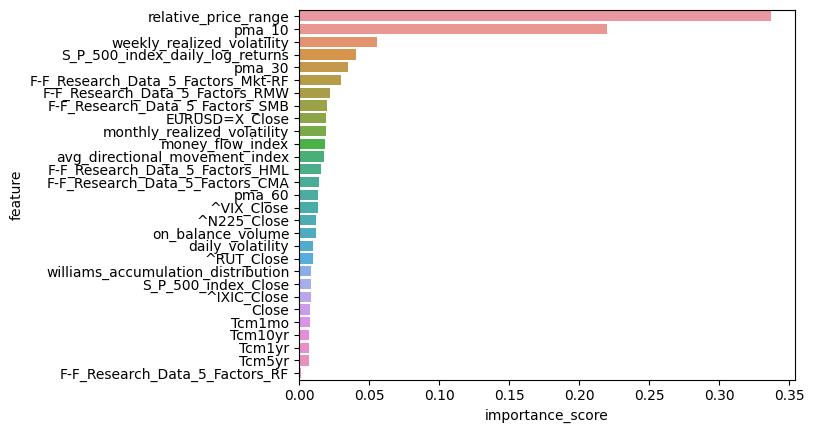

In [111]:
df_feat_imp = pd.DataFrame(
    [X_train.columns, rfr.regressor.feature_importances_], 
    index=["feature", "importance_score"]
    ).T.sort_values(by="importance_score", ascending=False)
sns.barplot(x=df_feat_imp["importance_score"], y=df_feat_imp["feature"], orient="horizonal")
# plt.xlim(0, 0.1)
plt.show()

**Histogram Gradient Boosting Regressor**

In [112]:
PARAMS_HGBR = {
    "loss": "squared_error",
    "max_depth": None,
    "validation_fraction": 0.2,
}

hgbr = HistGradientBoostingReg(**PARAMS_HGBR)
hgbr.fit_regressor(X_train, Y_train)
Y_pred = hgbr.predict_regressor(X_test)
hgbr.score_regressor(X_test, Y_test)

**Stochastic Gradient Descent Regressor**

In [71]:
PARAMS_SGDR = {
    "loss": "squared_error",#"squared_error",
    "max_iter": 100,
    "penalty": "l2",
    "validation_fraction": 0.2,
    "early_stopping": True,
    "n_iter_no_change": 10,
    "learning_rate": "optimal",
}

sgdr = SGDReg(scaler="StandardScaler", **PARAMS_SGDR)
sgdr.fit_regressor(X_train, Y_train)
Y_pred = sgdr.predict_regressor(X_test)
sgdr.score_regressor(X_test, Y_test)

**Elastic Net Regressor**

In [72]:
PARAMS_ENR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

enr = ElasticNetReg(**PARAMS_ENR)
enr.fit_regressor(X_train, Y_train)
Y_pred = enr.predict_regressor(X_test)
enr.score_regressor(X_test, Y_test)

**ThielSen Regressor**

In [73]:
PARAMS_TSR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

tsr = TheilSenReg(**PARAMS_TSR)
tsr.fit_regressor(X_train, Y_train)
Y_pred = tsr.predict_regressor(X_test)
tsr.score_regressor(X_test, Y_test)

**RANSAC Regressor**

In [74]:
PARAMS_RANSACR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

ransacr = RANSACReg(**PARAMS_RANSACR)
ransacr.fit_regressor(X_train, Y_train)
Y_pred = ransacr.predict_regressor(X_test)
ransacr.score_regressor(X_test, Y_test)

## Plot Prediction

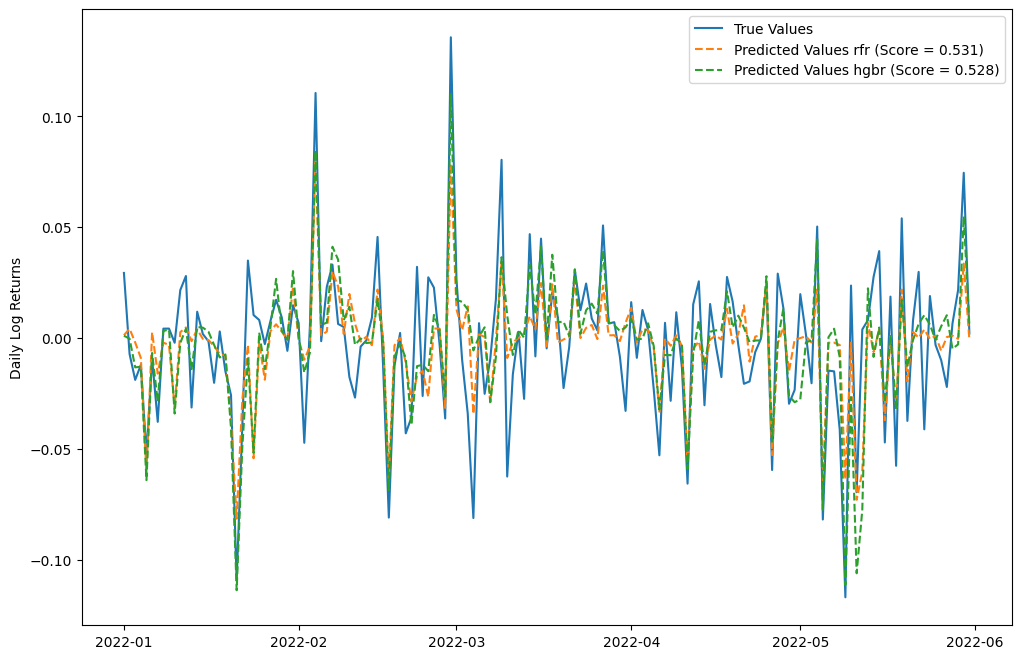

In [113]:
## Rest of the models are not good :(\
## But the problem is idk the theory there, so IDK how to make them better (even if possible in the first place)

dict_regressors = {
    "rfr": rfr, 
    "hgbr": hgbr, 
    # "sgdr": sgdr, 
    # "enr": enr, 
    # "tsr": tsr, 
    # "ransacr": ransacr,
}

plt.figure(figsize=(12, 8))

PLOT_RANGE = ("2022-01-01", "2022-05-31")

plt.plot(Y_test[PLOT_RANGE[0]: PLOT_RANGE[1]], label="True Values")

for regressor_name, regressor in dict_regressors.items():
    # if regressor_name=='sgdr':
    #     continue
    plt.plot(
        regressor.predict_regressor(X_test)[PLOT_RANGE[0]: PLOT_RANGE[1]],
        label=f"Predicted Values {regressor_name} (Score = {round(regressor.score, 3)})",
        ls='--',
    )

# plt.plot(
#     Y_pred_ARIMA[PLOT_RANGE[0]: PLOT_RANGE[1]],
#     label=f"Predicted Values ARIMA (Score = {r2_score(Y_test, Y_pred_ARIMA)})",
#     ls='--'
#     )
# plt.title(f"Score= {round(rfr.score, 3)}")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()

# Trading Strategy

In [114]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'out-of-sampling' # 'test' or 'out-of-sampling'

In [115]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [116]:
ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_var='Close')
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

**Trading Strategy from True Values**

In [117]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

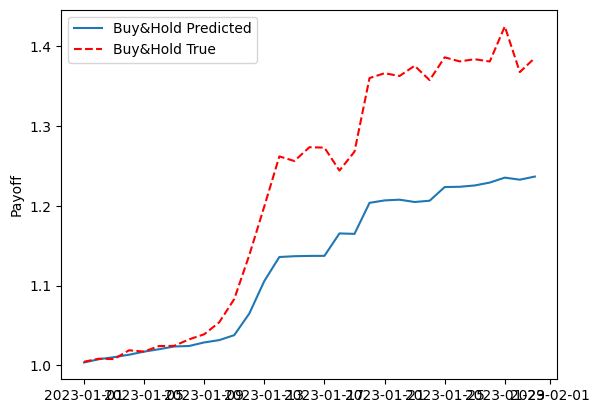

In [118]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [119]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30'
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [120]:
df_regression_payoffs#[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08             1      1.000647              0       1.000000   
2023-01-09             1      1.004978              0       1.000000   
2023-01-10             1      1.007809              0       1.000000   
2023-01-11             1      1.013924              0       1.000000   
2023-01-12             1      1.040276              0       1.000000   
2023-01-13             1      1.080091              0       1.000000   
2023-01-14             1      1.109489              0       1.000000   
2023-01-15             1      1.110464              0       1.000000   
2023-01-16             1      1.110827              0       1.000000   
2023-01-17             1      1.110901              0       1.000000   
2023-01-18             1      1.138346              0       1.000000   
2023-01-19             1      1.137792              0       1.000000   
2023-01-20             1      1.175742              0       1.000000   
2023-01-21             1      1.178737              0       1.000000   
2023-01-22             1      1.179613              0       1.000000   
2023-01-23             1      1.176789              0       1.000000   
2023-01-24             1      1.178360              0       1.000000   
2023-01-25             1      1.195070              0       1.000000   
2023-01-26             1      1.195395              0       1.000000   
2023-01-27             1      1.197030              0       1.000000   
2023-01-28             1      1.200544              0       1.000000   
2023-01-29             1      1.206606              0       1.000000   
2023-01-30             1      1.204069              0       1.000000   
2023-01-31             1      1.207911              1       1.003191   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.0               0             1.0   
2023-01-04              0            1.0               0             1.0   
2023-01-05              0            1.0               0             1.0   
2023-01-06              0            1.0               0             1.0   
2023-01-07              0            1.0               0             1.0   
2023-01-08              0            1.0               0             1.0   
2023-01-09              0            1.0               0             1.0   
2023-01-10              0            1.0               0             1.0   
2023-01-11              0            1.0               0             1.0   
2023-01-12              0            1.0               0             1.0   
2023-01-13              0            1.0               0             1.0   
2023-01-14              0            1.0               0             1.0   
2023-01-15              0            1.0               0             1.0   
2023-01-16              0            1.0               0             1.0   
2023-01-17              0            1.0               0             1.0   
2023-01-18              0            1.0               0             1.0   
2023-01-19              0            1.0               0             1.0   
2023-01-20              0            1.0               0             1.0   
2023-01-21              0            1.0               0             1.0   
2023-01-22              0          

In [121]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30'
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [122]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08             1      1.007993              0       1.000000   
2023-01-09             1      1.014191              0       1.000000   
2023-01-10             1      1.028814              0       1.000000   
2023-01-11             1      1.057231              0       1.000000   
2023-01-12             1      1.110941              0       1.000000   
2023-01-13             1      1.170542              0       1.000000   
2023-01-14             1      1.231636              0       1.000000   
2023-01-15             1      1.226016              0       1.000000   
2023-01-16             1      1.242858              0       1.000000   
2023-01-17             1      1.242382              0       1.000000   
2023-01-18             1      1.214313              0       1.000000   
2023-01-19             1      1.237452              0       1.000000   
2023-01-20             1      1.327396              0       1.000000   
2023-01-21             1      1.333299              0       1.000000   
2023-01-22             1      1.329946              0       1.000000   
2023-01-23             1      1.342415              0       1.000000   
2023-01-24             1      1.324860              0       1.000000   
2023-01-25             1      1.352739              0       1.000000   
2023-01-26             1      1.347752              0       1.000000   
2023-01-27             1      1.350438              0       1.000000   
2023-01-28             1      1.347647              0       1.000000   
2023-01-29             1      1.390464              0       1.000000   
2023-01-30            -1      1.446217              0       1.000000   
2023-01-31             1      1.465036              1       1.013012   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.0               0             1.0   
2023-01-04              0            1.0               0             1.0   
2023-01-05              0            1.0               0             1.0   
2023-01-06              0            1.0               0             1.0   
2023-01-07              0            1.0               0             1.0   
2023-01-08              0            1.0               0             1.0   
2023-01-09              0            1.0               0             1.0   
2023-01-10              0            1.0               0             1.0   
2023-01-11              0            1.0               0             1.0   
2023-01-12              0            1.0               0             1.0   
2023-01-13              0            1.0               0             1.0   
2023-01-14              0            1.0               0             1.0   
2023-01-15              0            1.0               0             1.0   
2023-01-16              0            1.0               0             1.0   
2023-01-17              0            1.0               0             1.0   
2023-01-18              0            1.0               0             1.0   
2023-01-19              0            1.0               0             1.0   
2023-01-20              0            1.0               0             1.0   
2023-01-21              0            1.0               0             1.0   
2023-01-22              0          

# Performance

In [123]:
df_regression_signals = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals), 
    index=df_regression_signals.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals = pd.concat([df_regression_signals, signal_buy_and_hold], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals,
)

In [124]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

signal_SMA_7 signal_SMA_30 signal_SMA_90  \
cumulative_return             0.352078      0.013012           0.0   
annualized_return            33.869075      0.164418           0.0   
average_daily_log_returns     0.010031       0.00042           0.0   
annualized_volatility         0.441746       0.04465           0.0   
sharpe_ratio                  0.433833      0.179605           NaN   
annualized_sharpe_ratio       1.488634      0.616289           NaN   
sortino_ratio                 0.883063           inf           NaN   
max_drawdown                  1.551657           1.0           NaN   
calmar_ratio                 21.827687      0.164418           NaN   

                          signal_SMA_180 signal_EMA_7 signal_EMA_30  \
cumulative_return                    0.0      0.37879       0.37879   
annualized_return                    0.0    42.901527     42.901527   
average_daily_log_returns            0.0     0.010665      0.010665   
annualized_volatility                0.0     0.438658      0.438658   
sharpe_ratio                         NaN     0.464501      0.464501   
annualized_sharpe_ratio              NaN     1.593867      1.593867   
sortino_ratio                        NaN     0.847637      0.847637   
max_drawdown                         NaN     1.551657      1.551657   
calmar_ratio                         NaN    27.648853     27.648853   

                          signal_EMA_90 signal_EMA_180 signal_BBS_7  \
cumulative_return               0.37879        0.37879    -0.101727   
annualized_return             42.901527      42.901527    -0.717238   
average_daily_log_returns      0.010665       0.010665    -0.003369   
annualized_volatility          0.438658       0.438658     0.249276   
sharpe_ratio                   0.464501       0.464501     -0.25824   
annualized_sharpe_ratio        1.593867       1.593867    -0.886113   
sortino_ratio                  0.847637       0.847637     -0.25824   
max_drawdown                   1.551657       1.551657          inf   
calmar_ratio                  27.648853      27.648853         -0.0   

                          signal_BBS_14 signal_BBS_30 signal_RSI_7  \
cumulative_return             -0.052192           0.0    -0.274586   
annualized_return             -0.468016           0.0     -0.97717   
average_daily_log_returns     -0.001684           0.0    -0.010037   
annualized_volatility          0.179091           0.0     0.441696   
sharpe_ratio                  -0.179605           NaN    -0.434138   
annualized_sharpe_ratio       -0.616289           NaN    -1.489682   
sortino_ratio                 -0.179605           NaN     -0.47404   
max_drawdown                        inf           NaN     2.812722   
calmar_ratio                       -0.0           NaN    -0.347411   

                          signal_RSI_14 signal_RSI_30 signal_buy_and_hold  
cumulative_return             -0.145144      0.026563             0.38524  
annualized_return             -0.842204      0.361619            45.38127  
average_daily_log_returns     -0.004849      0.000874            0.010816  
annualized_volatility          0.380464      0.146059            0.437567  
sharpe_ratio                  -0.243512      0.114282            0.472248  
annualized_sharpe_ratio       -0.835575      0.392143            1.620449  
sortino_ratio                 -0.257509      0.367763            0.835658  
max_drawdown                   2.812722      1.324521            1.551657  
calmar_ratio                  -0.299427      0.273019            29.24698

## Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

In [125]:
metric = 'cumulative_return'

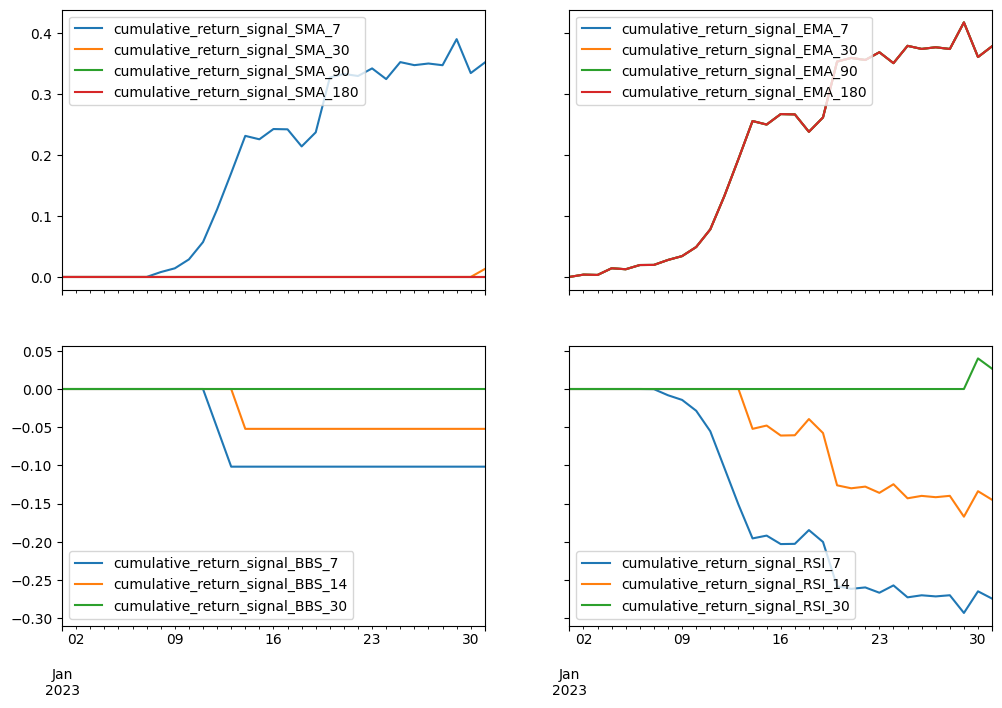

In [126]:
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI']

nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if metric in col and strategy in col]]
    df_plot.plot(ax=ax)
plt.show()

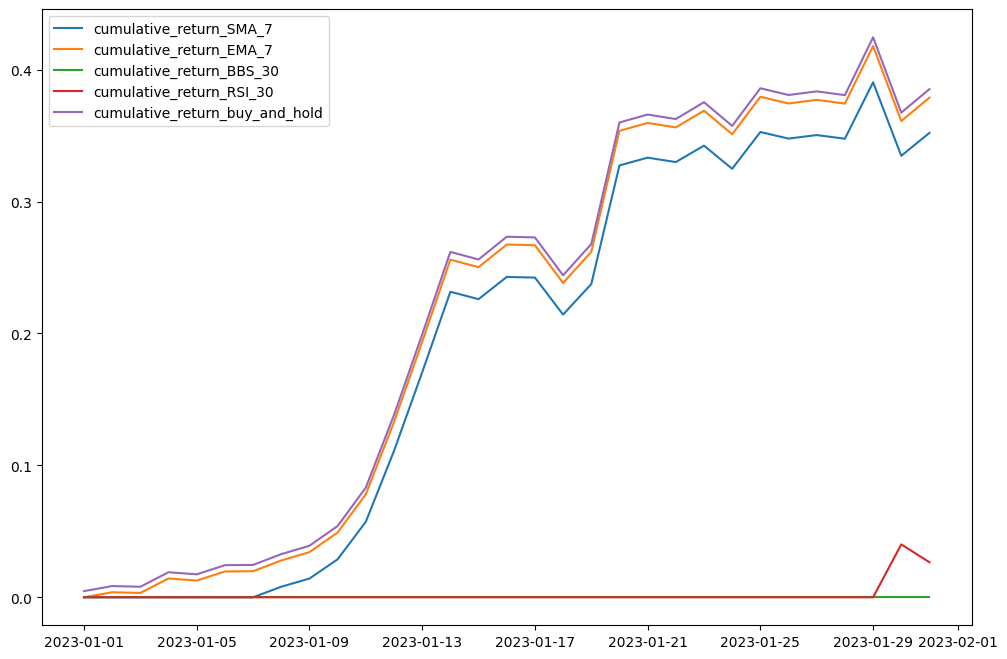

In [127]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{metric}_signal_{strategy}'], label=f"{metric}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Comapre Sharpe Ratio**

In [128]:
metric = 'sharpe_ratio'

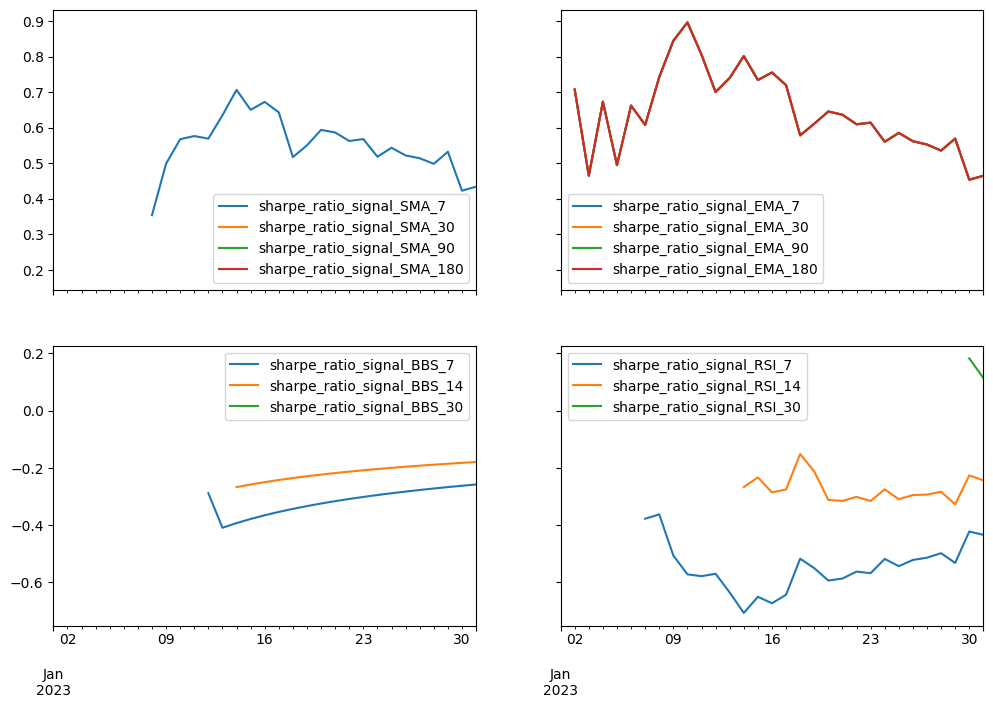

In [129]:
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI']

nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(metric) and strategy in col]]
    df_plot.plot(ax=ax)
plt.show()

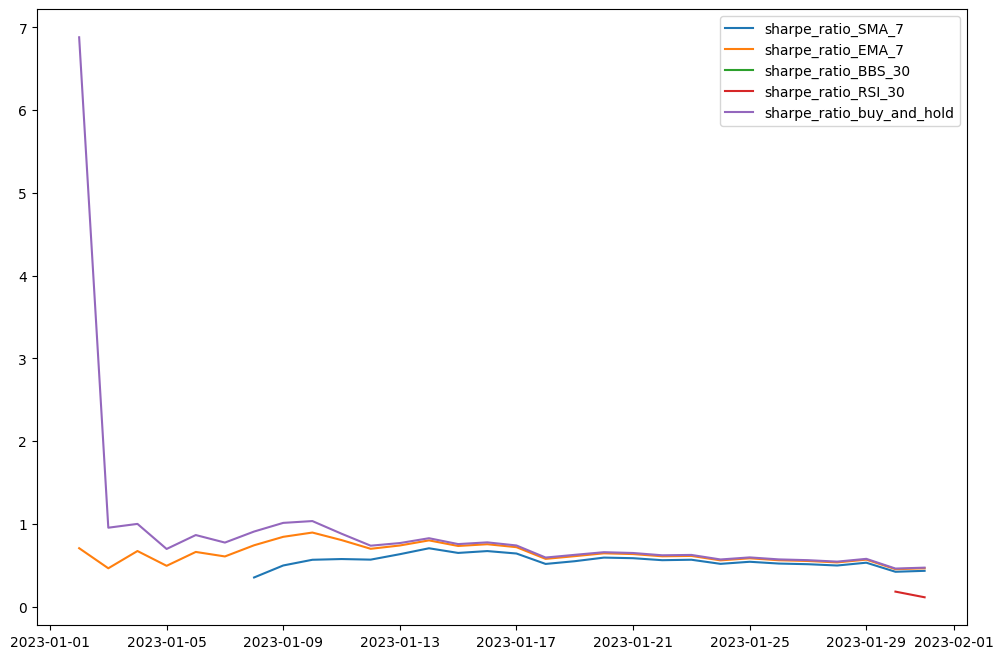

In [130]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{metric}_signal_{strategy}'], label=f"{metric}_{strategy}")
plt.legend()
plt.show()